In [1]:
pacman::p_load(tidyverse, lubridate, stars, sf)

source("src/edf_theme.r")
source("src/functions.r")
theme_set(theme_edf())

options(repr.plot.width=8, repr.plot.height=3)
options(scipen=999)  # turn off scientific numbers

In [2]:
# census tracts clipped to the study area
sf_tracts <- st_read("data/study_area_census_tracts_clipped/study_area_census_tracts_clipped.shp") %>%
    rename(geoid = FIPS) %>%
    mutate(geoid = as.character(geoid))

df_tracts <- sf_tracts %>% st_set_geometry(NULL)
# df_tracts <- read_csv("data/study_area_census_tracts/study_area_census_tracts.csv") %>%
#     rename(geoid = FIPS) %>%
#     mutate(geoid = as.character(geoid))


# table of all the raster cells which are covered by census tracts - used to limit wide output table for smaller size
df_study_clipped <- read_csv("data/raster_template/raster_template_study_area_lookup.csv") %>%
    filter(study_area == 1)

nrow(sf_tracts)
head(sf_tracts)

Reading layer `study_area_census_tracts_clipped' from data source `C:\Users\gslater\OneDrive - Environmental Defense Fund - edf.org\GCA Work\2022 04 - HG ToxPi file processing\data\02_study_area_census_tracts_clipped\study_area_census_tracts_clipped.shp' using driver `ESRI Shapefile'
Simple feature collection with 1017 features and 1 field
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 890267.3 ymin: 4144950 xmax: 1064688 ymax: 4330396
Projected CRS: NAD83(2011) / Texas South Central


Parsed with column specification:
cols(
  cell_id = col_double(),
  study_area = col_double()
)


[1] 1017

,geoid,geometry
,<chr>,<MULTIPOLYGON [m]>
1,48039660100,MULTIPOLYGON (((963184.6 41...
2,48039660200,MULTIPOLYGON (((963387.7 41...
3,48039660300,MULTIPOLYGON (((960180 4197...
4,48039660400,MULTIPOLYGON (((959989.4 42...
5,48039660500,MULTIPOLYGON (((953609.1 41...
6,48039660601,MULTIPOLYGON (((950018 4197...


In [62]:
rt <- read_stars("data/raster_template/raster_template.tif")

In [34]:
# lookup file for datasets to be processed
file_key <- read_csv("data/CVI for Gulf_2 - csv 2022_07_04.csv")

nrow(file_key)
head(file_key)

Parsed with column specification:
cols(
  .default = col_character(),
  `Adverse Direction` = col_double(),
  to_process = col_double(),
  processed = col_double()
)
See spec(...) for full column specifications.


[1] 47

Path To File,Document Name,CensusIdName,Clean/Final Data,Domain,Subcategory,Data Column Name,Unit of Data,Indicator Name,indicator_name_short,⋯,Format,Geographic Level,URL,Download Date,GEOID Column Name,missing_data_value,to_process,processed,Notes,Data notes
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Health/LifeExpectancy.csv,LifeExpectancy,Census Tract,YES,Health,Overall Physical Health,"Life expectancy at birth, as of 2010-2015.",NA,Life Expectancy,LifeExpectancy,⋯,Census Tract,Census Tract,NA,05/08/2021,Census Tract,-999,1,1,W Verified. This is a rate.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CASTHMA,NA,Current asthma among adults aged >=18 years,CASTHMA,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,STROKE,NA,Stroke among adults aged >=18 years,STROKE,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,COPD,NA,Chronic obstructive pulmonary disease among adults aged >=18 years,COPD,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CHD,NA,Coronary heart disease among adults aged >=18 years,CHD,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CANCER,NA,Cancer (excluding skin cancer) among adults aged >=18 years,CANCER,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA


In [3]:
nrow(df_tracts)

[1] 1017

In [4]:
df_study_clipped %>% count(study_area)

study_area,n
<dbl>,<int>
1,1697501


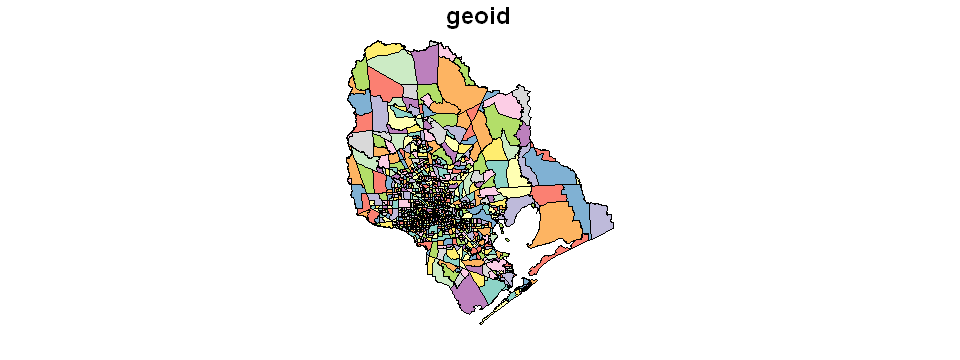

In [5]:
plot(sf_tracts[, 1])

## Processing #1 - create study area only datasets for each file (only run once)

In [26]:
targ <- file_key %>%
#     filter(to_process == 1 & processed != 1) %>%
    filter(`Document Name` %in% c("PercentHousing1940-1969", "Native Lands_63022"))  %>% 
    distinct(`Path To File`, `GEOID Column Name`) %>% 
    as.data.frame()

targ

Path To File,GEOID Column Name
<chr>,<chr>
Social/PercentHousing1940-1969.csv,FIPS Code
Social/Native Lands_63022.csv,FIPS


In [33]:
for (i in 1:nrow(targ)) {
# for (i in 1:1) {

    # take file path and geoid column name from file key
    path <- paste0("data/ToxPi_inputs/", targ[i, "Path To File"])
    geoid_col_name <- targ[i, "GEOID Column Name"]
    
    # read in file and create new character geoid field
    df <- read_csv(path) %>%
        mutate(geoid = as.character(!!as.symbol(geoid_col_name)))
    
    # get list of all required data fields in file from file_key
    fields <- filter(file_key, `Path To File` == targ[i, "Path To File"]) %>%
    distinct(`Data Column Name`) %>% 
    pull()
    
    # filter to study area tracts, select required columns, and save
    df %>%
        filter(geoid %in% df_tracts$geoid) %>%
        select(geoid, all_of(fields)) %>%
        write_csv(str_replace(path, ".csv", " - study_area.csv"))

}

Parsed with column specification:
cols(
  `Census Tract` = col_character(),
  State = col_character(),
  `FIPS Code` = col_double(),
  `Formatted FIPS` = col_character(),
  `Estimated percent of all housing units built 1940 to 1969, as of` = col_double()
)
Parsed with column specification:
cols(
  OID_ = col_double(),
  STATE_ABBR = col_character(),
  STATE_FIPS = col_double(),
  COUNTY_FIPS = col_double(),
  STCOFIPS = col_double(),
  TRACT_FIPS = col_double(),
  FIPS = col_double(),
  POPULATION = col_double(),
  POP_SQMI = col_double(),
  SQMI = col_double(),
  Area_of_intersect_sqmiles = col_double(),
  Percent_na_lands = col_double()
)


### Processing 1.1 - manual fix for health data

In [226]:
# this is just to create a wide dataset from the narrow table the data is provided in
health_fields <- c("CASTHMA", "STROKE", "COPD", "CHD", "CANCER", "ACCESS2")

df_health_wide <- read_csv("data/Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv") %>%
    rename(geoid = LocationName) %>%
    filter(geoid %in% df_tracts$geoid, MeasureId %in% health_fields) %>%
    select(geoid, Data_Value, MeasureId)

nrow(df_health_wide)
head(df_health_wide)

Parsed with column specification:
cols(
  .default = col_character(),
  Year = col_double(),
  Data_Value = col_double(),
  Data_Value_Footnote_Symbol = col_logical(),
  Data_Value_Footnote = col_logical(),
  Low_Confidence_Limit = col_double(),
  High_Confidence_Limit = col_double(),
  TotalPopulation = col_double()
)
See spec(...) for full column specifications.


[1] 7152

geoid,Data_Value,MeasureId
<chr>,<dbl>,<chr>
48039662100,3.2,STROKE
48039661300,3.9,STROKE
48039661601,6.4,CANCER
48039660702,1.9,STROKE
48039661502,6.1,CHD
48039660300,7.7,CASTHMA


In [237]:
df_health_wide %>% 
    spread(value = Data_Value, key = MeasureId) %>%
    head() 
#     write_csv("data/Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release - study_area.csv")

### Processing 1.2 - manual categorisation for medically underserved

In [8]:
# recode categorical variable
df <- read_csv("data/ToxPi_inputs/Health/MedicallyUnderserved - study_area.csv") %>% 
    rename(label = `Medically Underserved Areas (MUA), as of 2020.`) %>%
    mutate(value = case_when(label == "Not an MUA or MUP" ~ 1, 
                             label %in% c("Medically Underserved Population", 
                                          "Medically Underserved Population - Governor's Exception") ~ 2,
                             label == "Medically Underserved Area" ~ 3,
                             TRUE ~ 0)) %>%
    rename(`Medically Underserved Areas (MUA), as of 2020.` = value)

df %>% count(`Medically Underserved Areas (MUA), as of 2020.`, label)

Parsed with column specification:
cols(
  geoid = col_double(),
  `Medically Underserved Areas (MUA), as of 2020.` = col_character()
)


"Medically Underserved Areas (MUA), as of 2020.",label,n
<dbl>,<chr>,<int>
1,Not an MUA or MUP,663
2,Medically Underserved Population,74
2,Medically Underserved Population - Governor's Exception,28
3,Medically Underserved Area,252


In [9]:
df

geoid,label,"Medically Underserved Areas (MUA), as of 2020."
<dbl>,<chr>,<dbl>
48039660100,Not an MUA or MUP,1
48039660200,Not an MUA or MUP,1
48039660300,Not an MUA or MUP,1
48039660400,Not an MUA or MUP,1
48039660500,Not an MUA or MUP,1
48039660601,Not an MUA or MUP,1
48039660602,Not an MUA or MUP,1
48039660701,Not an MUA or MUP,1
48039660702,Not an MUA or MUP,1


In [10]:
df %>% select(-label) %>% write_csv("data/ToxPi_inputs/Health/MedicallyUnderserved - coded - study_area.csv")

In [75]:
count(df, `Medically Underserved Areas (MUA), as of 2020.`)

"Medically Underserved Areas (MUA), as of 2020.",n
<chr>,<int>
Medically Underserved Area,252
Medically Underserved Population,74
Medically Underserved Population - Governor's Exception,28
Not an MUA or MUP,663


### Processing 1.3 - manual rasterisation for redlining data

In [13]:
rl <- st_read("data/ToxPi_inputs/Infrastructure/redlining/redlining_A-E_districts_study_area.gpkg") %>%
    st_transform(6587) %>%
    mutate(value = case_when(holc_grade == "A" ~ 1,
                             holc_grade == "B" ~ 2,
                             holc_grade == "C" ~ 3,
                             holc_grade == "D" ~ 4))

nrow(rl)
head(rl)

Reading layer `redlining_A-E_districts_study_area' from data source `C:\Users\gslater\OneDrive - Environmental Defense Fund - edf.org\GCA Work\2022 04 - HG ToxPi file processing\data\01_Infrastructure\redlining\redlining_A-E_districts_study_area.gpkg' using driver `GPKG'
Simple feature collection with 44 features and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -95.40254 ymin: 29.26924 xmax: -94.77255 ymax: 29.81406
Geodetic CRS:  WGS 84


[1] 44

,state,city,name,holc_id,holc_grade,neighborho,area_descr,geom,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<MULTIPOLYGON [m]>,<dbl>
1,TX,Galveston,NA,A,A,8973,"{ """" : """" }",MULTIPOLYGON (((1006136 416...,1
2,TX,Galveston,NA,B,B,8974,"{ """" : """" }",MULTIPOLYGON (((1009392 417...,2
3,TX,Galveston,NA,C,C,8976,"{ """" : """" }",MULTIPOLYGON (((1007171 416...,3
4,TX,Galveston,NA,D,D,8983,"{ """" : """" }",MULTIPOLYGON (((1010352 417...,4
5,TX,Houston,NA,NA,C,7903,"{ """" : """" }",MULTIPOLYGON (((956536 4212...,3
6,TX,Houston,NA,NA,B,7904,"{ """" : """" }",MULTIPOLYGON (((959256.3 42...,2


In [14]:
rl %>% st_set_geometry(NULL) %>% count(holc_grade, value)

holc_grade,value,n
<fct>,<dbl>,<int>
A,1,5
B,2,12
C,3,16
D,4,11


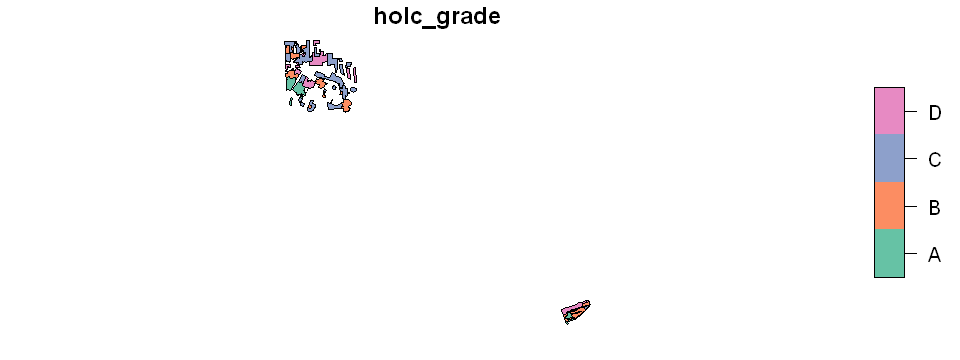

In [15]:
plot(rl[, "holc_grade"])

In [27]:
head(rl)

,OBJECTID,state,city,name,holc_id,holc_grade,neighborho,area_descr,Shape_Length,Shape_Area,geom,value
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<MULTIPOLYGON [m]>,<dbl>
1,8011,TX,Galveston,,C,C,8976,"{ """" : """" }",0.04608466,0.00004489546,MULTIPOLYGON (((1007171 416...,1
2,8012,TX,Galveston,,D,D,8983,"{ """" : """" }",0.14172299,0.00042157447,MULTIPOLYGON (((1010352 417...,1
3,8013,TX,Houston,,,C,7903,"{ """" : """" }",0.10239977,0.00027372826,MULTIPOLYGON (((956536 4212...,1
4,8015,TX,Houston,,,C,7905,"{ """" : """" }",0.09143210,0.00026535854,MULTIPOLYGON (((960150 4212...,1
5,8017,TX,Houston,,,C,7907,"{ """" : """" }",0.03581940,0.00008339763,MULTIPOLYGON (((961137.5 42...,1
6,8018,TX,Houston,,,C,7908,"{ """" : """" }",0.02543743,0.00004264769,MULTIPOLYGON (((958109.1 42...,1


In [16]:
# rasterise polygon data and write to tif to check in QGIS

# copy raster template, set all cells to NA, then all study area cells to 0
# this should ensure study area is 0 or 1 based on RL areas, beyond study area will be NA
rl_rast_blank <- rt
rl_rast_blank[[1]][] <- NA
rl_rast_blank[[1]][df_study_clipped$cell_id] <- 0


rl_rast <- rl %>% 
    select(value) %>%
    st_rasterize(template = rl_rast_blank, options = "ALL_TOUCHED=TRUE")

rl_rast

write_stars(rl_rast, "data/ToxPi_inputs/Infrastructure/redlining/redlining_A-E_districts_study_area.tif")

stars object with 2 dimensions and 1 attribute
attribute(s), summary of first 100000 cells:
     value      
 Min.   :0      
 1st Qu.:0      
 Median :0      
 Mean   :0      
 3rd Qu.:0      
 Max.   :0      
 NA's   :91698  
dimension(s):
  from   to  offset delta                       refsys point values    
x    1 2132  890267   100 NAD83(2011) / Texas South... FALSE   NULL [x]
y    1 1884 4330396  -100 NAD83(2011) / Texas South... FALSE   NULL [y]

In [86]:
# transform to df and write to csv file
rl_output <- raster_to_df(rl_rast)

nrow(rl_output)
rl_output %>% drop_na() %>% nrow()
head(rl_output)

rl_output %>% drop_na() %>% write_csv("outputs/ToxPi_inputs_processed/Infrastructure_Redlining1.csv")

[1] 4016688

[1] 1697511

,cell_id,value
,<dbl>,<dbl>
1,1,NA
2,2,NA
3,3,NA
4,4,NA
5,5,NA
6,6,NA


In [18]:
rl_output %>% count(value)

value,n
<dbl>,<int>
0,1686589
1,1337
2,2435
3,4729
4,2421
NA,2319177


### Processing 1.4 - manual rasterisation for NFIP data

In [55]:
zip_sf <- st_read("data/zip_codes_study_area/Zip codes study area.gpkg") %>%
    st_transform(6587)

nfip_df <- read_csv("data/ToxPi_inputs/Social/FEMA_NFIP_market_penetration.csv") %>%
    select(AFFGEOID10, market_pen = `Market Penetration`)

nrow(zip_sf)
nrow(nfip_df)

Reading layer `Zip codes study area' from data source `C:\Users\gslater\OneDrive - Environmental Defense Fund - edf.org\GCA Work\2022 04 - HG ToxPi file processing\data\02_zip_codes_study_area\Zip codes study area.gpkg' using driver `GPKG'
Simple feature collection with 224 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -96.30693 ymin: 28.91208 xmax: -94.00579 ymax: 30.94042
Geodetic CRS:  NAD83


Parsed with column specification:
cols(
  .default = col_double(),
  AFFGEOID10 = col_character()
)
See spec(...) for full column specifications.


[1] 224

[1] 367

In [75]:
# inner join zip code sf to data
# and clip to study area extent

tracts_boundary_sf <- sf_tracts %>% st_union()

nfip_sf <- zip_sf %>% 
    select(AFFGEOID10) %>%
    inner_join(nfip_df, by = "AFFGEOID10") %>% 
    st_intersection(tracts_boundary_sf)

Warning message:
"Column `AFFGEOID10` joining factor and character vector, coercing into character vector"Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"

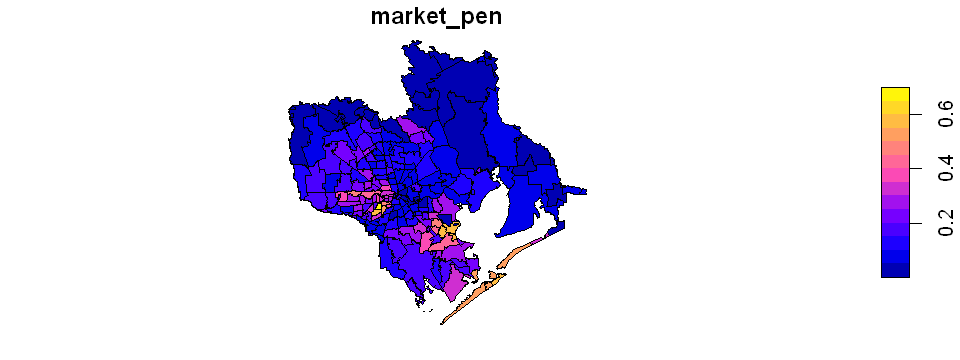

In [76]:
plot(nfip_sf["market_pen"])

In [80]:
new_rast <- rt
new_rast[[1]][] <- NA

# rasterise sf file and export to .tif
nfip_rt <- nfip_sf %>% 
    select(value = market_pen) %>%
    st_rasterize(template = new_rast)

nfip_rt %>% write_stars("outputs/ToxPi_inputs_processed/Social_FloodInsPenetration.tif")

In [79]:
# write NFIP raster to csv
raster_to_df(nfip_rt) %>% 
    drop_na() %>%
    write_csv("outputs/ToxPi_inputs_processed/Social_FloodInsPenetration.csv")

In [47]:
head(zip_sf)

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geom
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,77575,8600000US77575,77575,619991214,17419213,MULTIPOLYGON (((-94.85061 3...
2,77445,8600000US77445,77445,458544625,7003639,MULTIPOLYGON (((-95.96928 3...
3,77518,8600000US77518,77518,7509514,47494,MULTIPOLYGON (((-95.00817 2...
4,77583,8600000US77583,77583,432246130,8204018,MULTIPOLYGON (((-95.41597 2...
5,77535,8600000US77535,77535,813235411,8784382,MULTIPOLYGON (((-95.0707 30...
6,77086,8600000US77086,77086,17574575,13632,MULTIPOLYGON (((-95.52172 2...


In [48]:
head(nfip_df)

OBJECTID,Zipcode,AFFGEOID10,Total A-Zone Structures,Total Structures Out of Flood Plain,Total VE-Zone Structures,Total X500-Zone Structures,Total Structures,Total A-Zone Policies,Total Policies Out of Flood Plain,Total VE-Zone Policies,Total XX500-Zone Policies,Total Policies,A-Zone Market Penetration,Market Penetration Out of Flood Plain,VE-Zone Market Penetration,X500-Zone Market Penetration,Market Penetration,Shape_Area,Shape_Length
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,77630,8600000US77630,4753,7656,0,4042,16451,1128,1447,0,718,3293,0.237324,0.189002,0,0.177635,0.200170,359294057,179435.00
2,77584,8600000US77584,4168,22802,0,1558,28528,1190,5054,0,464,6708,0.285509,0.221647,0,0.297818,0.235137,110432168,76457.95
3,77089,8600000US77089,2983,402,0,11176,14561,1954,37,0,2512,4503,0.655045,0.092040,0,0.224767,0.309251,45612532,42899.19
4,77536,8600000US77536,668,11949,0,1517,14134,300,3120,0,613,4033,0.449102,0.261110,0,0.404087,0.285340,44901819,36119.95
5,77447,8600000US77447,249,4420,0,150,4819,69,208,0,17,294,0.277108,0.047059,0,0.113333,0.061009,353948341,121780.77
6,77038,8600000US77038,2504,3867,0,1216,7587,596,248,0,109,953,0.238019,0.064132,0,0.089638,0.125610,32783280,30082.85


## Processing #2 - rasterise

In [36]:
targ2 <- file_key %>%
    filter(to_process == 1) %>%
#     filter(`Document Name` == "MedicallyUnderserved") %>%
    as.data.frame()

targ2
# targ2[17:18, ]

Path To File,Document Name,CensusIdName,Clean/Final Data,Domain,Subcategory,Data Column Name,Unit of Data,Indicator Name,indicator_name_short,⋯,Format,Geographic Level,URL,Download Date,GEOID Column Name,missing_data_value,to_process,processed,Notes,Data notes
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Health/LifeExpectancy.csv,LifeExpectancy,Census Tract,YES,Health,Overall Physical Health,"Life expectancy at birth, as of 2010-2015.",NA,Life Expectancy,LifeExpectancy,⋯,Census Tract,Census Tract,NA,05/08/2021,Census Tract,-999,1,1,W Verified. This is a rate.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CASTHMA,NA,Current asthma among adults aged >=18 years,CASTHMA,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,STROKE,NA,Stroke among adults aged >=18 years,STROKE,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,COPD,NA,Chronic obstructive pulmonary disease among adults aged >=18 years,COPD,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CHD,NA,Coronary heart disease among adults aged >=18 years,CHD,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease,CANCER,NA,Cancer (excluding skin cancer) among adults aged >=18 years,CANCER,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv,PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release,LocationID,YES,Health,Chronic Disease Prevention,ACCESS2,NA,Current lack of health insurance among adults aged 18-64 years,ACCESS2,⋯,Census Tract (Model based),Census Tract (Model based),Link,21/12/2021,LocationName,none,1,1,W Verified. This is a % per total population in CST.,NA
Health/MedicallyUnderserved - coded.csv,MedicallyUnderserved,Census Tract,YES* (see note),Health,Access to Care,"Medically Underserved Areas (MUA), as of 2020.",NA,MedicallyUnderserved,MedicallyUnderserved,⋯,Census Tract,Census Tract,NA,13/08/2021,Census Tract,none,1,0,"Suggest categorizing as follows: Not an MUA or MUP=1 Medically Underserved Area (MUA)=2 (A shortage of primary health care services for residents within a geographic area (e.g., a whole county, a group of neighboring counties, a group of urban census tracts, and others geographic areas). Medically Underserved Population (MUP)=3 (Are specific sub- groups of people living in a defined geographic area with a shortage of primary health care services and facing economic, cultural or linguistic barriers to access to health care (e.g., homeless, low-income, Medicaid-eligible, Native American, migrant farmworkers, among others popul

In [37]:
# set raster template values to NA
rt[[1]][] <- NA

# create logging df
log_df <- data.frame()

# df for wide output of all raster data - these are just all raster cells covered by census tracts, not full raster area
wide_output_df <- data.frame("cell_id" = df_study_clipped$cell_id)


# loop through data sets in the target list

for (i in 1:nrow(targ2)) {
# for (i in 1:2) {

    # take file path from file key
    path_data <- paste0("data/ToxPi_inputs/", targ2[i, "Path To File"]) %>%
        str_replace(".csv", " - study_area.csv")
    
    # __ FIELDS AND FILE PATHS __________________________________________ # 
    
    # create nice short name for indicator by combining domain and short indicator
    dom <- targ2[i, "Domain"]
    ind <- targ2[i, "indicator_name_short"]
    
    ind_name <- paste(dom, ind, sep = "_")
    
    # pull important fields from data_key
    data_field <- targ2[i, "Data Column Name"]
#     missing_field <- as.numeric(targ2[i, "missing_data_value"])
    
    # new folder path to save file-specific outputs
#     path_out <- file.path(getwd(), "output/ToxPi_inputs_processed", ind_name)
#     dir.create(path_out)
    
    
    # __ LOGGING AND FILE READ-IN __________________________________________ # 
    
#     sink(file.path(path_out, "log.txt"))
    print("---------------------------------------------------------")
    print("FILE READ")
    print(paste0("Processing file: ", path_data))
    print(paste0("Processing date: ", now()))
    

    # read in file (with field type default as numeric, geoid as character), 
    # rename data field as value, and restrict to tracts in sf
    df <- read_csv(path_data, col_types = cols(.default = "n", geoid = "c")) %>%
        rename(value = !!as.symbol(data_field)) %>%
        select(geoid, value) %>%
        filter(geoid %in% sf_tracts$geoid)
    
    # array of all non missing values
    non_missing_vals <- df %>%
        filter(!is.na(value) & value != -999) %>%
        pull(value) 
    
    # count missing values
    n_missing_vals <- df %>%
        filter(is.na(value) | value == -999) %>%
        nrow()
    
    # set value to 0 before if clause
    missing_tracts <- data.frame()
    
    # __ MISSING VALUES AND TRACTS __________________________________________ # 
    
    # if there are missing census tracts or missing values
    if ((nrow(df) < nrow(sf_tracts)) | (n_missing_vals > 0)){
        
        # if tracts in the input data have NA or -999 values
        if (n_missing_vals > 0){

            # replace missing values (NA or -999) with -999
            df <- df %>%
                mutate(value = ifelse(is.na(value) | value == -999, 
                                      -999,
                                      value))

            print("MISSING DATA")
            print(paste0(n_missing_vals, " missing values found in file"))
#             print(paste0("replacing with study area median: ", median(non_missing_vals)))
            
        }
        
        # if there are fewer census tracts in the input data (df) than the study area
        if (nrow(df) < nrow(sf_tracts)){
        
            # geoids of missing tracts
            missing_tracts <- df_tracts %>%
                select(geoid) %>%
                filter(!geoid %in% df$geoid) #%>%
    #             mutate(value = median(non_missing_vals))

            # give missing geoids median value and join to orig data
            df <- df %>%
                full_join(missing_tracts, by = "geoid") #%>%
    #             mutate(value = ifelse(is.na(value.x), value.y, value.x))

            print("MISSING TRACTS")
            print(paste0(nrow(missing_tracts), " tracts are missing from input file"))
#             print(paste0("replacing with study area median: ", median(non_missing_vals)))
            
        }
        
    } 
    
#     # __DATA OVERVIEWS__________________________________________ # 
    
#     pl_hist <- ggplot(df, aes(value)) + geom_histogram() +
#         labs(title = paste0("Distribution: ", ind_name),
#              x = data_field) +
#         scale_fill_edf("health")
    
#     pl_box <- ggplot(df, aes(value)) + geom_boxplot(width = .5, alpha = .8) +
#         labs(title = paste0("Distribution: ", ind_name),
#              x = data_field) +
#         theme(axis.text.y = element_blank())
    
#     ggsave(file.path(path_out, paste0("fig histogram - ", ind_name, ".png")),
#            pl_hist,
#            units = "cm", width = 15, height = 6)
    
#     ggsave(file.path(path_out, paste0("fig boxplot - ", ind_name, ".png")),
#            pl_box,
#            units = "cm", width = 12, height = 4)
    
    
    # __ RASTERISATION __________________________________________ #
    
    # create sf file for new data by joining to tracts sf, and keep only data value
    sf_new_data <- sf_tracts %>% 
        inner_join(df, by = "geoid") %>%
        select(value)
    
    print("GEOGRAPHY FUNCTIONS")
    print(paste0("No. of census tracts in study area: ", nrow(sf_tracts)))
    print(paste0("No. of joined census tracts joined to ", ind_name, " data: ", nrow(sf_new_data)))
    
    # create raster dataset
    r_new_data <- sf_new_data %>%
        st_rasterize(template = rt)
    
    # create data frame output for dataset
    df_new_data <- data.frame("cell_id" = seq(1, length(r_new_data[[1]]), 1),
                              "value" = NA)

    df_new_data$value <- r_new_data[[1]][df_new_data$cell_id]
    
#     write_stars(r_new_data, file.path(path_out, paste0(ind_name, ".tif")))
#     write_csv(df_new_data %>% drop_na(), file.path(path_out, paste0(ind_name, ".csv")))
    
    print("OUTPUTS")
    print(paste0("Created file: ", paste0(ind_name, ".tif")))
    print(paste0("n records: ", format(length(r_new_data[[1]]), big.mark=",")))
    print(paste0("Created file: ", paste0(ind_name, ".csv")))
    print(paste0("n records (with NAs removed): ", format(nrow(df_new_data %>% drop_na()), big.mark=",")))
    
#     append data to wide table
    wide_output_df[ind_name] <- r_new_data[[1]][wide_output_df$cell_id]
    
#     # __ QUICK MAP __________________________________________ #
    
#     pl_map <- ggplot() +  
#         geom_raster(data = as.data.frame(r_new_data), aes(x = x, y = y, fill = value)) +
#         scale_fill_viridis(na.value = "white") +
#         coord_sf(datum = NA) +
#         labs(title = paste0("Rasterised data in study area: ", ind_name)) +
#         theme(plot.title = element_text(size = 8))
    
#     ggsave(file.path(path_out, paste0("fig raster map - ", ind_name, ".png")),
#            pl_map,
#            units = "cm", width = 10, height = 10)


    
    # __ LOG DF __________________________________________ #
    log <- data.frame("file" = as.character(ind_name),
                      "n_missing_values" = n_missing_vals,
                      "n_missing_tracts" = nrow(missing_tracts),
                      "study_area_min" = min(non_missing_vals),
                      "study_area_median" = median(non_missing_vals),
                      "study_area_max" = max(non_missing_vals),
                      stringsAsFactors = F)
    
    log_df <- bind_rows(log_df, log)

#     print("---------------------------------------------------------")
}


# save log & wide df
fn_log <- paste0("ToxPi_DataProcessingLog_", format(now(), "%Y%m%d_%H%M"), ".csv")
write_csv(log_df, paste0("outputs/ToxPi_inputs_processed/", fn_log))

# fn_output <- paste0("ToxPiDataInput_v2.0_", format(now(), "%Y%m%d"), ".csv")
# write_csv(wide_output_df, paste0("outputs/ToxPi_inputs_processed/", fn_output))

[1] "---------------------------------------------------------"
[1] "FILE READ"
[1] "Processing file: data/01_Health/LifeExpectancy - study_area.csv"
[1] "Processing date: 2022-07-19 13:03:20"
[1] "MISSING DATA"
[1] "99 missing values found in file"
[1] "GEOGRAPHY FUNCTIONS"
[1] "No. of census tracts in study area: 1017"
[1] "No. of joined census tracts joined to Health_LifeExpectancy data: 1017"
[1] "OUTPUTS"
[1] "Created file: Health_LifeExpectancy.tif"
[1] "n records: 4,016,688"
[1] "Created file: Health_LifeExpectancy.csv"
[1] "n records (with NAs removed): 1,697,501"
[1] "---------------------------------------------------------"
[1] "FILE READ"
[1] "Processing file: data/01_Health/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release - study_area.csv"
[1] "Processing date: 2022-07-19 13:03:20"
[1] "MISSING TRACTS"
[1] "2 tracts are missing from input file"
[1] "GEOGRAPHY FUNCTIONS"
[1] "No. of census tracts in study area: 1017"
[1] "No. of joined census tracts join

In [85]:
fn_output <- paste0("ToxPi_DataInput_v2.1_", format(now(), "%Y%m%d"), ".csv")
write_csv(wide_output_df, paste0("outputs/ToxPi_inputs_processed/", fn_output))

# paste0("outputs/ToxPi_inputs_processed/", fn_output)

In [81]:
head(wide_output_df)

,cell_id,Health_LifeExpectancy,Health_CASTHMA,Health_STROKE,Health_COPD,Health_CHD,Health_CANCER,Health_ACCESS2,Health_MedicallyUnderserved,Social_BelowPoverty,⋯,Social_MobileHomes,Social_Crowding,Social_NoVehicle,Social_GroupQuarters,Social_ForeclosureRate,Infrastructure_NoBroadbandAccess,Infrastructure_RetailFood,Infrastructure_HousingBuiltPastVsNow,Infrastructure_HousingAffordability1,Infrastructure_HousingAffordability2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,553,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105
2,554,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105
3,2683,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105
4,2684,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105
5,2685,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105
6,2686,82.2,8.9,3.8,7.6,6.6,7.7,21.3,1,0.2603,⋯,0.9731,0.6159,0.0792,0.44,NA,0.2,NA,9.98,35,105


In [7]:
nrow(df_new_data)
nrow(df_new_data %>% drop_na())

[1] 4016688

[1] 1697501

In [8]:
write_csv(df_new_data %>% drop_na(), file.path(path_out, paste0(ind_name, "_clipped.csv")))

In [12]:
write_stars(r_new_data, file.path(path_out, paste0(ind_name, ".tif")))

In [10]:
file.path(path_out, paste0(ind_name, ".tif"))

[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed2/Social_BelowPoverty/Social_BelowPoverty.tif"

## Admin files

In [22]:
df_study_clipped <- df_new_data %>% 
    mutate(study_area = ifelse(is.na(value), 0, 1)) %>%
    select(cell_id, study_area)

# write_csv(df_study_clipped, "data/raster_template/raster_template_study_area_lookup.csv")

nrow(df_study_clipped)
head(df_study_clipped)

[1] 4016688

,cell_id,study_area
,<dbl>,<dbl>
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0


In [23]:
rt_study_area <- rt

rt_study_area[[1]][] <- NA

# set raster cells present in input df to values from input df
rt_study_area[[1]][df_study_clipped$cell_id] <- df_study_clipped$study_area

# write output tif
write_stars(rt_study_area, "data/raster_template/raster_template_study_area_lookup.tif")

## Processing #3 - join to single wide file

In [41]:
nrow(wide_output_df)

[1] 1697501

In [44]:

# write_csv(wide_output_df, paste0("outputs/ToxPi_inputs_processed/", fn_output))

paste0("outputs/ToxPi_inputs_processed/", fn_output)

[1] "data/09_processed/ToxPiDataInput_v2.0_20220719.csv"

In [45]:
# join red lining data to wide output file and save output

fn_output <- paste0("ToxPi_DataInput_v2.1_", format(now(), "%Y%m%d"), ".csv")

wide_output_df %>% 
    left_join(select(rl_output, cell_id, Infrastructure_Redlining1 = value), 
              by = "cell_id") %>% 
#     head()
    write_csv(paste0("outputs/ToxPi_inputs_processed/", fn_output))

In [20]:
nrow(wide_output_df)

[1] 1697501

In [6]:
targ3 <- file_key %>%
    filter(processed == 1) %>%
    as.data.frame()

targ3

Path To File,Document Name,CensusIdName,Clean/Final Data,Domain,Subcategory,Data Column Name,Unit of Data,Indicator Name,indicator_name_short,⋯,Format,Geographic Level,URL,Download Date,GEOID Column Name,missing_data_value,to_process,processed,Notes,Data notes
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Health/LifeExpectancy.csv,LifeExpectancy,Census Tract,YES,Health,Overall Physical Health,"Life expectancy at birth, as of 2010-2015.",NA,Life Expectancy,LifeExpectancy,⋯,Census Tract,Census Tract,NA,05/08/2021,Census Tract,-999,1,1,W Verified. This is a rate.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Socioeconomic Status,EPL_POV,NA,Below Poverty,BelowPoverty,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Socioeconomic Status,EPL_UNEMP,NA,Unemployed,Unemployed,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Socioeconomic Status,EPL_PCI,NA,Income,Income,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Socioeconomic Status,EPL_NOHSDP,NA,No High School Diploma,NoHSDiploma,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Housing Composition & Disability,EPL_AGE65,NA,Aged 65 or Older,Aged65Older,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Housing Composition & Disability,EPL_AGE17,NA,Aged 17 or Younger,Aged17Younger,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Housing Composition & Disability,EPL_DISABL,NA,Civilian with a Disability,CivilianWithDisability,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA
Social/SVI2018_US.csv,SVI2018_US,FIPS,YES,Social,Housing Composition & Disability,EPL_SNGPNT,NA,Single-Parent Households,SingleParentHhld,⋯,Census Tract,Census Tract,Link,03/12/2020,FIPS,-999,1,1,W Verified. Medians calculated separately in R.,NA


In [7]:

df_wide <- read_csv("data/processed/Health_LifeExpectancy/Health_LifeExpectancy.csv") %>%
    select(cell_id)

# df_wide
for (i in 1:nrow(targ3)) {
# for (i in 1:2) {

    
    # create nice short name for indicator by combining domain and short indicator
    dom <- targ3[i, "Domain"]
    ind <- targ3[i, "indicator_name_short"]
    
    ind_name <- paste(dom, ind, sep = "_")
    
    # read in the processed dataset using the ind_name for folder and filenames
    path_df <- file.path(getwd(), paste0("data/processed/", ind_name, "/", ind_name, ".csv"))
    print(path_df)
    
    df <- read_csv(path_df)
    
    # add the processed value to df_wide named with the ind_name
    df_wide[ind_name] <- df["value"]
    
    }

Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Health_LifeExpectancy/Health_LifeExpectancy.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_BelowPoverty/Social_BelowPoverty.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Unemployed/Social_Unemployed.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Income/Social_Income.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_NoHSDiploma/Social_NoHSDiploma.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Aged65Older/Social_Aged65Older.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Aged17Younger/Social_Aged17Younger.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_CivilianWithDisability/Social_CivilianWithDisability.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_SingleParentHhld/Social_SingleParentHhld.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Minority/Social_Minority.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_SpeaksEnglishLessWell/Social_SpeaksEnglishLessWell.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_MultiUnitStructures/Social_MultiUnitStructures.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_MobileHomes/Social_MobileHomes.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_Crowding/Social_Crowding.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_NoVehicle/Social_NoVehicle.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_GroupQuarters/Social_GroupQuarters.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Social_ForeclosureRate/Social_ForeclosureRate.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Infrastructure_NoBroadbandAccess/Infrastructure_NoBroadbandAccess.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Infrastructure_RetailFood/Infrastructure_RetailFood.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Infrastructure_HousingAffordability1/Infrastructure_HousingAffordability1.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


[1] "C:/Users/gslater/OneDrive - Environmental Defense Fund - edf.org/GCA Work/2022 04 - HG ToxPi file processing/data/processed/Infrastructure_HousingAffordability2/Infrastructure_HousingAffordability2.csv"


Parsed with column specification:
cols(
  cell_id = col_double(),
  value = col_double()
)


In [8]:
head(df_wide)

cell_id,Health_LifeExpectancy,Social_BelowPoverty,Social_Unemployed,Social_Income,Social_NoHSDiploma,Social_Aged65Older,Social_Aged17Younger,Social_CivilianWithDisability,Social_SingleParentHhld,⋯,Social_MultiUnitStructures,Social_MobileHomes,Social_Crowding,Social_NoVehicle,Social_GroupQuarters,Social_ForeclosureRate,Infrastructure_NoBroadbandAccess,Infrastructure_RetailFood,Infrastructure_HousingAffordability1,Infrastructure_HousingAffordability2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15
2,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15
3,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15
4,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15
5,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15
6,78.4,0.7899,0.2862,0.5149,0.6896,0.7678,0.8263,0.8177,0.8258,⋯,0,0.8999,0.6373,0.5497,0,0.11,0.23,0,55,15


In [10]:
# count the no. of NAs per row, this is to make sure that the 
# drop_na below isn't getting rid of rows where just one column is missing data
df_wide$na_count <- apply(is.na(df_wide), 1, sum)

count(df_wide, na_count)

na_count,n
<int>,<int>
0,3252160
21,764528


In [9]:
# get rid of rows with NA values and save file
df_wide %>% 
    drop_na() %>%
    write_csv("data/processed/ToxPi_data_input_wide.csv")

In [9]:
# create a csv template of just cell_ids with 
df_wide %>% 
    drop_na() %>%
    write_csv("data/processed/ToxPi_data_input_wide.csv")

In [3]:
?drop_na()

In [4]:
df <- tibble(x = c(1, 2, NA), y = c("a", NA, "b"))
df %>% drop_na()
df %>% drop_na(x)

x,y
<dbl>,<chr>
1,a


x,y
<dbl>,<chr>
1,a
2,NA
